In [4]:
import numpy as np
import tensorflow as tf
from scipy.special import i0 as bessel

In [5]:
def log_bessel_approx_tf(x, m=5):
    def _log_bessel_approx_0(x):
        bessel_taylor_coefs = np.asarray([1.00000000e+00, 2.50000000e-01, 1.56250000e-02,
                                  4.34027778e-04, 6.78168403e-06], dtype='float32')
        deg = tf.reshape(tf.range(0, m, 1)*2, [1, -1])
        n_rows = tf.shape(x)[0]
        x_tiled = tf.tile(x, [1, m])
        deg_tiled = tf.tile(deg, [n_rows, 1])
        coef_tiled = tf.tile(bessel_taylor_coefs[0:m].reshape(1, m), [n_rows, 1])
        val = tf.log(tf.reduce_sum(tf.pow(x_tiled, tf.to_float(deg_tiled))*coef_tiled, axis=1))
        return tf.reshape(val, [-1,1])
    def _log_bessel_approx_large(x):
        return x - 0.5*tf.log(2*np.pi*x)
    res = tf.where(x>5.0, _log_bessel_approx_large(x), _log_bessel_approx_0(x))
    return res

In [6]:
x_vals = np.arange(-5,5).reshape(-1,1)

x_tf = tf.placeholder(tf.float32, shape=[None, 1])

log_bessel_tf = log_bessel_approx_tf(x_tf)

with tf.Session() as sess:
    log_bessel_vals_true = np.log(bessel(np.exp(x_vals)))
    log_bessel_vals_approx = log_bessel_tf.eval(feed_dict={x_tf:np.exp(x_vals)})

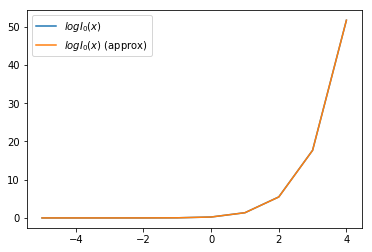

In [16]:
import matplotlib.pyplot as plt 
%matplotlib inline

#x_vals = np.arange(-3,100, 0.01)

plt.plot(x_vals, log_bessel_vals_true, label='$log I_0(x)$')
plt.plot(x_vals, log_bessel_vals_approx, label='$log I_0(x)$ (approx)')
#plt.plot(x_vals, np.exp(x_vals)*0.2 - log_bessel_vals_approx, label='log_likelihood')

plt.legend()
plt.show()

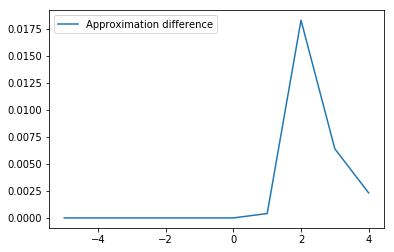

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(x_vals, np.abs(log_bessel_vals_true-log_bessel_vals_approx), label='Approximation difference')

plt.legend()
plt.show()

In [10]:
def von_mises_neg_log_likelihood_np(cosin_dist, log_kappa):
    log_likelihood = np.exp(log_kappa) * cosin_dist - \
                     np.log(2 * np.pi) - np.log(bessel(np.exp(log_kappa)))
    return -log_likelihood

In [71]:
def von_mises_neg_log_likelihood_tf(cosin_dist, log_kappa):
    log_likelihood = tf.exp(log_kappa) * cosin_dist - \
                     tf.log(2 * np.pi) - log_bessel_approx_tf(bessel(tf.exp(log_kappa)))
    return -log_likelihood

In [72]:
cosin_dist_tf = tf.placeholder(tf.float32, shape=[None, 1])
log_kappa_tf = tf.placeholder(tf.float32, shape=[None, 1])
vm_log_likelihood = von_mises_neg_log_likelihood_tf(cosin_dist_tf, log_kappa_tf)

TypeError: ufunc 'i0' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

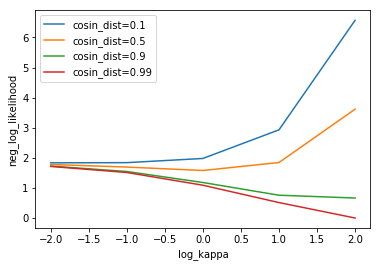

In [70]:
import matplotlib.pyplot as plt 

%matplotlib inline

log_kappa = np.arange(-2,3).reshape(-1,1)
cosin_dist = np.ones([log_kappa.shape[0],1])

with tf.Session() as sess:
    loss1 = vm_log_likelihood.eval(feed_dict={cosin_dist_tf:cosin_dist*0.1, log_kappa_tf:log_kappa})
    loss2 = vm_log_likelihood.eval(feed_dict={cosin_dist_tf:cosin_dist*0.5, log_kappa_tf:log_kappa})
    loss3 = vm_log_likelihood.eval(feed_dict={cosin_dist_tf:cosin_dist*0.9, log_kappa_tf:log_kappa})
    loss4 = vm_log_likelihood.eval(feed_dict={cosin_dist_tf:cosin_dist*0.99, log_kappa_tf:log_kappa})

plt.plot(log_kappa, loss1, label='cosin_dist=0.1')
plt.plot(log_kappa, loss2, label='cosin_dist=0.5')
plt.plot(log_kappa, loss3, label='cosin_dist=0.9')
plt.plot(log_kappa, loss4, label='cosin_dist=0.99')


#plt.plot(log_kappa, loss, label='Loss dependent on kappa')
#plt.plot(log_kappa, loss, label='Loss dependent on kappa')

plt.xlabel('log_kappa')
plt.ylabel('neg_log_likelihood')

plt.legend()
plt.show()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


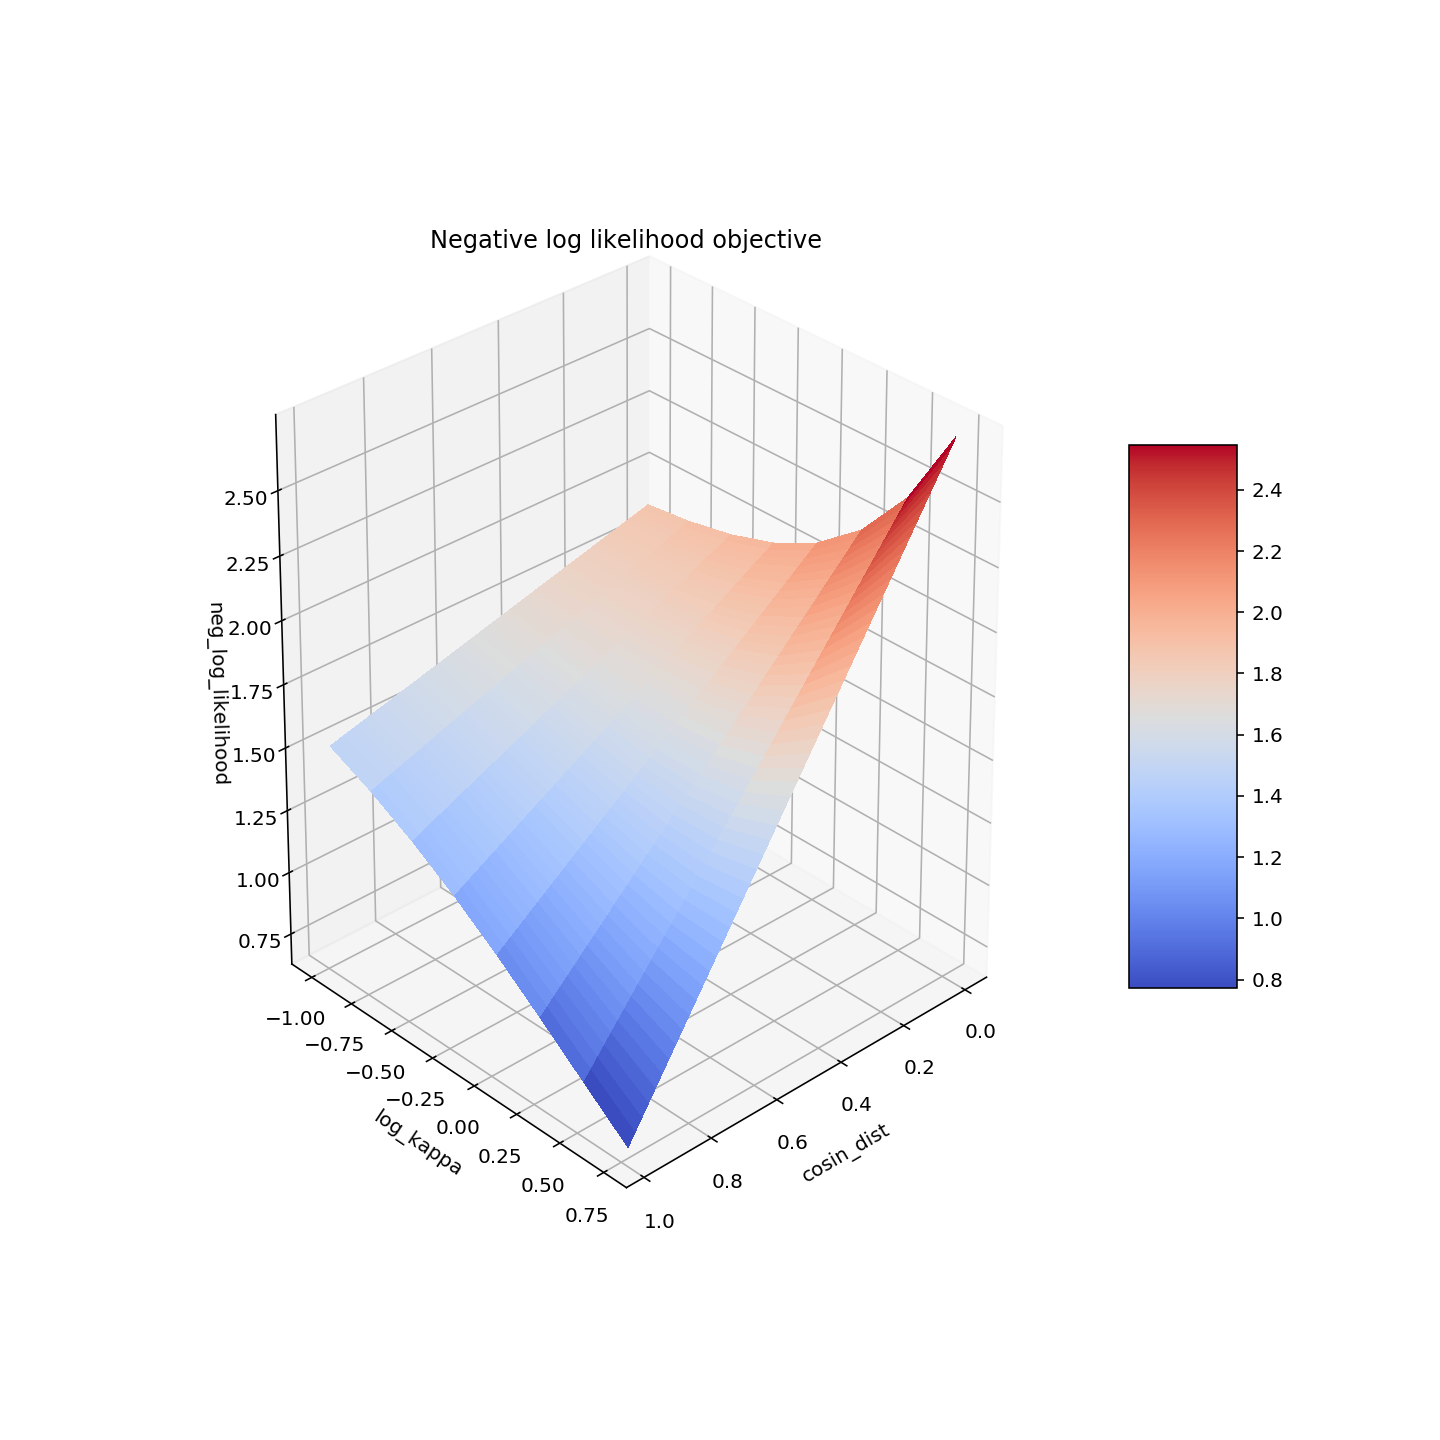

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


%matplotlib
#%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


cosin_dist = np.arange(0, 0.99, 0.01)
log_kappa = np.arange(-1, 1, 0.25)
cosin_dist, log_kappa = np.meshgrid(cosin_dist, log_kappa)
neg_log_likelihood = -(np.exp(log_kappa) * cosin_dist - np.log(2 * np.pi) - np.log(bessel(np.exp(log_kappa))))

surf = ax.plot_surface(cosin_dist, log_kappa, neg_log_likelihood, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('cosin_dist')
ax.set_ylabel('log_kappa')
ax.set_zlabel('neg_log_likelihood')
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("Negative log likelihood objective")
plt.show()